<a href="https://colab.research.google.com/github/eunsun53/ML_proj/blob/main/Alz_classification_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 알츠하이머 MRI 이미지 분류 - CNN

[kaggle 링크](https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images?datasetId=457093&sortBy=voteCount)

In [1]:
#드라이브-코랩 연동 
from google.colab import drive 
drive.mount('/content/gdrive/')


Mounted at /content/gdrive/


In [10]:
#디레토리 이동해서 zip파일 풀기 
cd /content/gdrive/MyDrive/elice

In [7]:
! unzip AlzData.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: train/MildDemented/mildDem207.jpg  
  inflating: train/MildDemented/mildDem208.jpg  
  inflating: train/MildDemented/mildDem209.jpg  
  inflating: train/MildDemented/mildDem21.jpg  
  inflating: train/MildDemented/mildDem210.jpg  
  inflating: train/MildDemented/mildDem211.jpg  
  inflating: train/MildDemented/mildDem212.jpg  
  inflating: train/MildDemented/mildDem213.jpg  
  inflating: train/MildDemented/mildDem214.jpg  
  inflating: train/MildDemented/mildDem215.jpg  
  inflating: train/MildDemented/mildDem216.jpg  
  inflating: train/MildDemented/mildDem217.jpg  
  inflating: train/MildDemented/mildDem218.jpg  
  inflating: train/MildDemented/mildDem219.jpg  
  inflating: train/MildDemented/mildDem22.jpg  
  inflating: train/MildDemented/mildDem220.jpg  
  inflating: train/MildDemented/mildDem221.jpg  
  inflating: train/MildDemented/mildDem222.jpg  
  inflating: train/MildDemented/mildDem223.jpg  
  inflating: train/MildDemented/mil

In [11]:
import os
os.listdir()

['melb_data.csv', 'AlzData.zip', 'test', 'train']

In [20]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
!pip install tensorflow==2.3.0 -q

     |████████████████████████████████| 320.4 MB 45 kB/s 
     |████████████████████████████████| 2.9 MB 39.9 MB/s 
     |████████████████████████████████| 459 kB 63.5 MB/s 
     |████████████████████████████████| 26.1 MB 1.6 MB/s 
     |████████████████████████████████| 20.1 MB 1.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.18.5 which is incompatible.
tables 3.7.0 requires numpy>=1.19.0, but you have numpy 1.18.5 which is incompatible.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.4.1 which is incompatible.
jaxlib 0.3.14+cuda11.cudnn805 requires numpy>=1.19, but you have numpy 1.18.5 which is incompatible.
jaxlib 0.3.14+cuda11.cudnn805 requires scipy>=1.5, but you have scipy 1.4.1 which is incompatible.
jax 0.3.14 requires numpy>=1.19, but you have numpy 1.18.5 which 

In [39]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

In [27]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

print(tf.version)

Number of replicas: 1
<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.7/dist-packages/tensorflow/_api/v2/version/__init__.py'>


In [28]:
IMAGE_SIZE = [176, 208]
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
EPOCHS = 10
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [29]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './train',
    validation_split = 0.2, 
    subset = 'training',
    seed = 1337,
    image_size = IMAGE_SIZE, 
    batch_size = BATCH_SIZE
)

Found 5121 files belonging to 4 classes.
Using 4097 files for training.


In [30]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './train',
    validation_split = 0.2, 
    subset = 'validation',
    seed = 1337,
    image_size = IMAGE_SIZE, 
    batch_size = BATCH_SIZE
)

Found 5121 files belonging to 4 classes.
Using 1024 files for validation.


In [31]:
list_dir_classes = os.listdir('./train')
list_dir_classes

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [36]:
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [37]:
train_ds.class_names = class_names
val_ds.class_names = class_names

NUM_CLASSES = len(class_names)

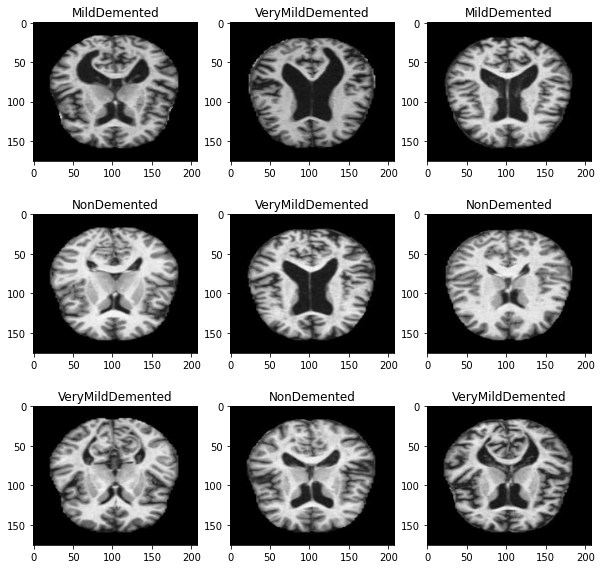

In [41]:
plt.figure(figsize = (10, 10))

for images, labels in train_ds.take(1): # .take(batch 가져오는 반복횟수)
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(train_ds.class_names[labels[i]])


In [43]:
def one_hot_label(image, label):
  label = tf.one_hot(label, NUM_CLASSES)

  return image, label

train_ds = train_ds.map(one_hot_label, num_parallel_calls = AUTOTUNE)
val_ds = val_ds.map(one_hot_label, num_parallel_calls = AUTOTUNE)

In [45]:
train_ds = train_ds.cache().prefetch(buffer_size =  AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size =  AUTOTUNE)

In [48]:
#이미지
NUM_IMAGES = []

for lable in class_name:
  dir_name = './train/' + lable[:-2] + 'ed'
  print('dir name: ', dir_name)
  NUM_IMAGES.append(len([name for name in os.listdir(dir_name)]))

dir name:  ./train/MildDemented
dir name:  ./train/ModerateDemented
dir name:  ./train/NonDemented
dir name:  ./train/VeryMildDemented


In [51]:
NUM_IMAGES # 각 레이블별 이미지 갯수 (mild, moderate, non, verymild)

[717, 52, 2560, 1792]

: 데이터 갯수가 불균형함 

# CNN 모델 생성 

In [70]:
#conv block 
def conv_block(filters_num):
  block = tf.keras.Sequential([
      tf.keras.layers.SeparableConv2D(filters_num, 3, activation = 'relu', padding = 'same'),
      tf.keras.layers.SeparableConv2D(filters_num, 3, activation = 'relu', padding = 'same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPool2D()]
  )
  return block

In [73]:
#dense block 
def dense_block(units, dropout_rate):
  block = tf.keras.Sequential([
      tf.keras.layers.Dense(units, activation = 'relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(dropout_rate)]
  )
  return block

In [75]:
def build_model():
  model = tf.keras.Sequential([
      tf.keras.Input(shape = (*IMAGE_SIZE, 3)),

      tf.keras.layers.SeparableConv2D(16, 3, activation = 'relu', padding = "same"),
      tf.keras.layers.SeparableConv2D(16, 3, activation = 'relu', padding = "same"),
      tf.keras.layers.MaxPool2D(),

      conv_block(32),
      conv_block(64),
      conv_block(128),
      tf.keras.layers.Dropout(0.2),

      conv_block(256),
      tf.keras.layers.Dropout(0.2),

      tf.keras.layers.Flatten(),
      dense_block(512, 0.7),
      dense_block(128, 0.5),
      dense_block(64, 0.3),
      
      tf.keras.layers.Dense(NUM_CLASSES, activation = 'softmax') ])

  return model

In [76]:
with strategy.scope():
  model = build_model()
   
  METRICS = [tf.keras.metrics.AUC(name = 'auc')]

  model.compile(optimizer = 'adam', loss = tf.losses.CategoricalCrossentropy(), metrics = METRICS)
  

In [77]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [ ]:
history = model.fit(
    train_ds, 
    validation_data = val_ds,
    callbacks = [checkpoint_cb, early_stopping_cb, lr_scheduler],
    epochs = EPOCHS
)